### 1. Import the libraries, load dataset, print shape of data, visualize the images in dataset.

First import all the necessary libraries to solve the project. NumPy, Pandas, matplotlib, OpenCV, Keras, sci-kit-learn and seaborn are the libraraies which will be used.

In [1]:
#Import necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Plants_Dataset/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### Before starting to train the model, we need to read and understand the data first. We will see the first 5 rows of the dataset to understand the data and we'll also try to find the unique values and the sahpe of the dataset followed by which we will visualize the images in the dataset.

In [3]:
#load dataset
plant_species_labels = pd.read_csv(root_path+'Labels.csv')

In [4]:
#display first 5 rows of the dataset
plant_species_labels.head(5)

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


In [5]:
#unique values in 'Label' column
np.unique(plant_species_labels['Label'])

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype=object)

In [6]:
#shape of 'plant_species_labels'
plant_species_labels.shape

(4750, 1)

In [7]:
# Number of unique values in the 'Label' column
len(np.unique(plant_species_labels['Label']))

12

In [8]:
#loading the numpy file containing image data 
image_arr = np.load(root_path+'images.npy')

In [9]:
# shape of image_arr (numpy array)
print(image_arr.shape)

(4750, 128, 128, 3)


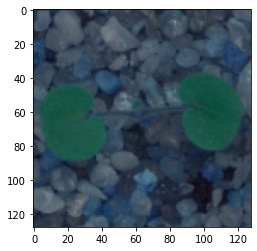

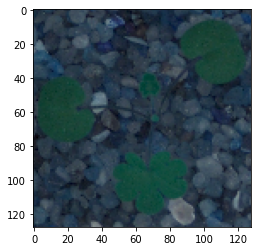

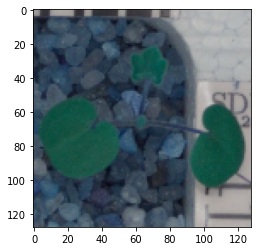

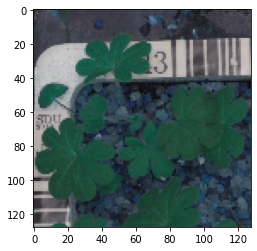

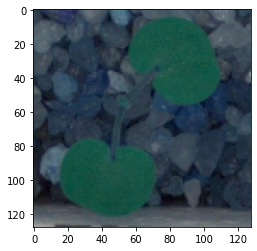

In [10]:
#Visualize images in the dataset
for i in range(0,5):
  plt.imshow(image_arr[i], cmap='gray' )
  plt.grid(False)
  plt.show()

### 2. Data Pre-processing:

#### For preparing the data for training we will apply Normalization and Gaussian Blur to remove the noise from the images so that feature extraction of the model can improve. After this we will visualize the resuling images from the dataset

Normalization

In [11]:
image_arr = image_arr.astype('float32')

In [12]:
normalized = image_arr / 255.0

In [13]:
normalized.shape

(4750, 128, 128, 3)

Gaussian Blurring

In [14]:
import cv2

In [15]:
def GaussianBlur(arr):
    for i in range(len(arr)):
    arr[i] = cv2.GaussianBlur(arr[i], (7, 7), 0)
    return arr

In [16]:
gaussian = GaussianBlur(normalized)

Visualization

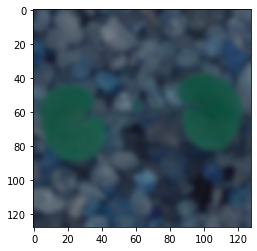

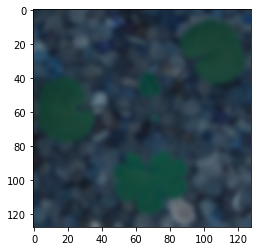

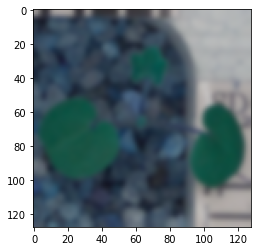

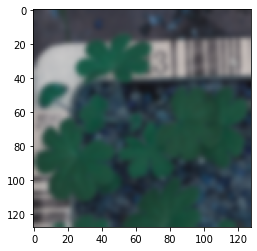

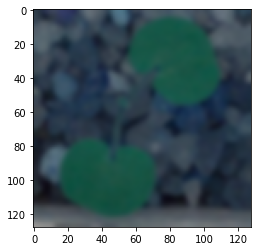

In [17]:
#Visualize the images in the dataset
for img in range(0,5):
  plt.imshow(gaussian[img], cmap='gray')
  plt.show()

### 3. Make data compatible 

#### The labels present in the dataset are in strings format and these are hard to process. So we’ll convert these labels into numerical data using one-hot-encoder.

Convert labels to one-hot-vectors

In [18]:
le = preprocessing.LabelEncoder()
le.fit(plant_species_labels['Label'])

LabelEncoder()

In [19]:
transformed_labels = le.transform(plant_species_labels['Label'])

In [20]:
new_plant_species_labels = np_utils.to_categorical(transformed_labels)

In [21]:
species = new_plant_species_labels.shape[1]
print(str(species))

12


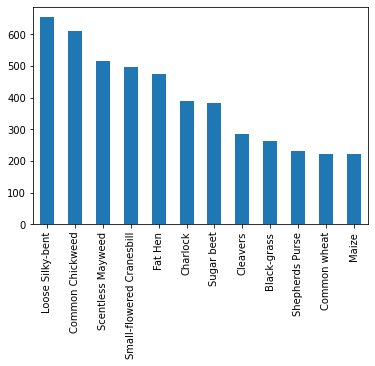

In [22]:
#bar plot showing plant species in the ascending order of their count in the dataset 
plant_species_labels['Label'].value_counts().plot(kind='bar')

#### Here we are preparing the data for training. We will spilt the dataset in training, testing and validation set. The dataset will be divided in the ratio of 0.3 for the train and test set respectively. And the test set will be divided in the ratio 0.5 for test and validation set resp. 

Split the dataset into training, testing, and validation set

In [23]:
X = gaussian
y = new_plant_species_labels

In [24]:
# splitting images and plant_species_labels into training and testing set 

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y)

In [25]:
# splitting images and plant_species_labels into testing and validation set 

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

Print the label for y_train[0]

In [26]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

Check the shape of data, Reshape data into shapes compatible with Keras models if it’s not already

In [27]:
X_train.shape

(3325, 128, 128, 3)

In [28]:
X_test.shape

(712, 128, 128, 3)

In [29]:
X_val.shape

(713, 128, 128, 3)

In [30]:
y_train.shape

(3325, 12)

In [31]:
y_test.shape

(712, 12)

In [32]:
y_val.shape

(713, 12)

The data is already in the form of a 2D - array of shape (128, 128, 3) with 3 color channels i.e Red, Green and Blue which is compatible with Keras models hence, there is no need to reshape the data.

#### PREVENTING OVERFITTING 
The problem of overfitting is severe in deep learning where deep neural networks get overfitted. The problem of overfitting affects our end results badly.
To avoid overfitting in this problem, we are using the ImageDataGenerator() function which randomly changes the characteristics of images and provides randomness in the data.

In [33]:
#using ImageDataGenerator to reduce the overfitting
generator = ImageDataGenerator(rotation_range = 180,zoom_range = 0.1,width_shift_range = 0.1,height_shift_range = 0.1,horizontal_flip = True,vertical_flip = True)
generator.fit(X_train)

### 4. Building CNN

#### In this problem, we are using a convolutional neural network. This neural network will take images as input and it will provide the final output as a species value. 

Defining the layers of the model 

In [34]:
#creating the CNN architecture 
model = Sequential()

# convolutional layer
model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(128,128, 3), activation='relu'))
model.add(BatchNormalization(axis=3))

# convolutional layer
model.add(Conv2D(filters=128, kernel_size=(3, 3),input_shape=(128,128, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

# convolutional layer
model.add(Conv2D(filters=256, kernel_size=(3, 3), input_shape=(128,128, 3),activation='relu'))
model.add(BatchNormalization(axis=3))

# convolutional layer
model.add(Conv2D(filters=256, kernel_size=(3, 3),input_shape=(128,128, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

# convolutional layer
model.add(Conv2D(filters=526, kernel_size=(3, 3),input_shape=(128,128, 3), activation='relu'))
model.add(BatchNormalization(axis=3))

# convolutional layer
model.add(Conv2D(filters=526, kernel_size=(3, 3),input_shape=(128,128, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(526, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(526, activation='relu'))
model.add(Dropout(0.5))

#output layer
model.add(Dense(12, activation='softmax'))

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 128)     512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 128)     147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 128)       512       
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 256)       2

Set optimizer and loss function. (Use Adam optimizer and categorical crossentropy)

In [36]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Fit and evaluate model and print confusion matrix

Now will we will fit the CNN model on our training set. Also we will use the ReduceLROnPlateau class to reduce the learning training rate of the model when the metric has stopped improving.

In [37]:
#reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=6,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [38]:
# fit the CNN model 
history = model.fit_generator(generator.flow(X_train, y_train, batch_size=32),
                              epochs = 75, validation_data = (X_val, y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0]//32,
                              callbacks=[reduce_lr])


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/75
103/103 - 59s - loss: 15.0637 - accuracy: 0.2390 - val_loss: 23.9358 - val_accuracy: 0.1220
Epoch 2/75
103/103 - 25s - loss: 5.8572 - accuracy: 0.2651 - val_loss: 8.2299 - val_accuracy: 0.1192
Epoch 3/75
103/103 - 26s - loss: 2.7668 - accuracy: 0.2697 - val_loss: 4.1070 - val_accuracy: 0.1220
Epoch 4/75
103/103 - 27s - loss: 2.2335 - accuracy: 0.3219 - val_loss: 6.4273 - val_accuracy: 0.1220
Epoch 5/75
103/103 - 27s - loss: 2.0655 - accuracy: 0.3456 - val_loss: 2.3482 - val_accuracy: 0.2118
Epoch 6/75
103/103 - 27s - loss: 1.9829 - accuracy: 0.3641 - val_loss: 1.6587 - val_accuracy: 0.4684
Epoch 7/75
103/103 - 27s - loss: 1.9802 - accuracy: 0.3599 - val_loss: 1.5887 - val_accuracy: 0.4811
Epoch 8/75
103/103 - 27s - loss: 1.8518 - accuracy: 0.3884 - val_loss: 1.6522 - val_accuracy: 0.4502
Epoch 9/75
103/103 - 28s - loss: 1.8207 - accuracy: 0.3948 - val_loss: 1.8862 - val_accuracy: 0.3759
Epoch 10/75
103/103 - 26s - loss: 1.7615 - accuracy: 0.4245 - val_loss: 1.5439 - val_accu

#### Seeking the accuracy rate in order to find that the training and validation accuracies and losses converge. 

In [39]:
print(model.evaluate(X_train, y_train))  # Evaluate on train set

print(model.evaluate(X_val, y_val))  # Evaluate on validation set

104/104 [==============================] - 7s 71ms/step - loss: 0.2518 - accuracy: 0.9020
[0.2518264949321747, 0.9019548892974854]
23/23 [==============================] - 2s 69ms/step - loss: 0.3670 - accuracy: 0.8654
[0.36702683568000793, 0.8653576374053955]


 #### We are getting our predictions on the testing dataset.

In [40]:
#predictions
y_predicted = model.predict(X_test)
y_predicted_species = np.argmax(y_predicted,axis = 1)
y_actual = np.argmax(y_test,axis = 1)

#### Evaluating the Model

A confusion matrix is a way to check how our model performs on data. It is a good way to visualize the results in order to check which class has the best and worst performances.Also we will be finding the accuracy and loss of the model on the test set.

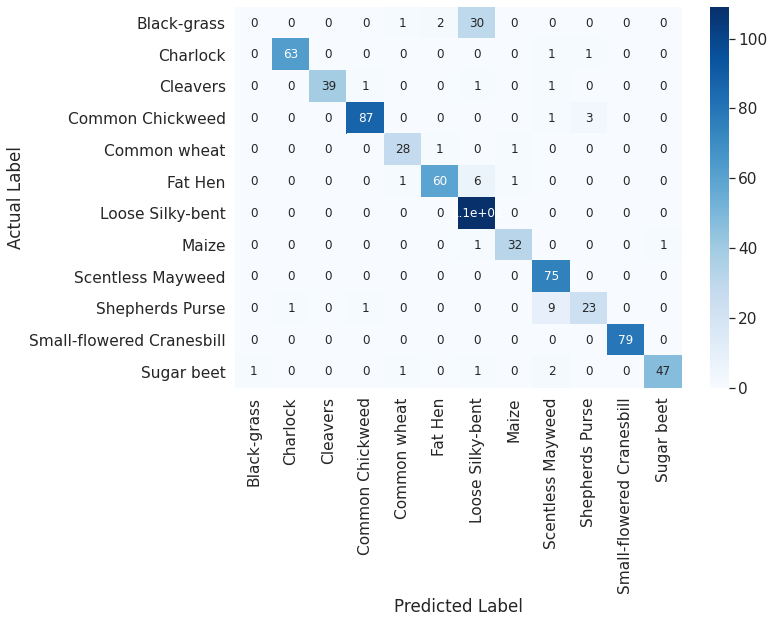

In [41]:
# confusion matrix
data = confusion_matrix(y_actual, y_predicted_species)
df_cm = pd.DataFrame(data, columns=np.unique(plant_species_labels['Label']), index = np.unique(plant_species_labels['Label']))
df_cm.index.name = 'Actual Label'
df_cm.columns.name = 'Predicted Label'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})

In [42]:
# Evaluate on test set
print(model.evaluate(X_test, y_test)) 

23/23 [==============================] - 2s 70ms/step - loss: 0.5001 - accuracy: 0.9017
[0.5001335144042969, 0.9016854166984558]


#### Now we will be testing out our model by predicting the label for the following data points and then comparing it with their actual label.

Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59].

In [43]:
print("Actual Label - ",y_actual[2])
print("Predicted Label - ",y_predicted_species[2])

Actual Label -  4
Predicted Label -  4


In [44]:
print("Actual Label - ",y_actual[3])
print("Predicted Label - ",y_predicted_species[3])

Actual Label -  3
Predicted Label -  3


In [45]:
print("Actual Label - ",y_actual[33])
print("Predicted Label - ",y_predicted_species[33])

Actual Label -  10
Predicted Label -  10


In [46]:
print("Actual Label - ",y_actual[36])
print("Predicted Label - ",y_predicted_species[36])

Actual Label -  7
Predicted Label -  7


In [47]:
print("Actual Label - ",y_actual[59])
print("Predicted Label - ",y_predicted_species[59])

Actual Label -  10
Predicted Label -  10


### Summary

For this project we used a self-built CNN model.

The model gave 0.9019548892974854 accuracy on training set and 0.8653576374053955 on the validation set. Also the model showed an accuracy of 0.9016854166984558 on the testing set.

According to the results shown in the above section where we have compared the predicted labels with the actual labels of the plant seedlings, we can see that all the predicted labels match with their respective actual label which shows the model's performance is good enough and the prediction of the model is acceptable for the application.

This model could be applied to help farmers to automatically classify the seedling plants and weed plants.

Using CNN’s and actually implementing it within agriculture can lower costs and help save plants thus produce more food.

We conclude that Artificial Intelligence can impact numerous industries and ways that are unimaginable and can impact the world such a positive way.